In [1]:
import tensorflow as tf
import os, glob
import numpy as np
import matplotlib.pyplot as plt

from models import *

In [2]:
def plot_rec(idx):
    fig = plt.figure(figsize=(4,8))

    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Original')
    plt.imshow(x_test[idx])

    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed')
    plt.imshow(x_pred[idx])
    plt.show()
    
def plot_scatter(data, mode=1):
    
    plt.figure()
    plt.figure(figsize=(30,30))
    ax = plt.subplot()
    
    x = data[:,0]
    y = data[:,1]
    
    xmin = min(x)-0.5
    xmax = max(x)+0.5
    ymin = min(y)-0.5
    ymax = max(y)+0.5
    print(xmin, xmax, ymin, ymax)
    plt.axis((xmin, xmax, ymin, ymax))

    plt.scatter(x,y, color = 'b')
    plt.savefig('%s/scatter'%(save_path))

    plt.show()
    
def plot_group(group_data, save_path, file_name):
    
    x, y = 5, 20
    fig = plt.figure(figsize=(20,20))
    for i in range(x):
        for j in range(y):
            idx = i*y+j
            plt.subplot(x, y, idx+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(group_data[idx])
            
    plt.savefig('%s/%s'%(save_path, file_name))
    plt.show() 

In [3]:
load_dir = 'data/w58y67_prepro/'

In [4]:
x_data = np.load('%s/x_test.npy'%(load_dir))
print('* data shape: ', x_data.shape)

* data shape:  (8761, 200, 48, 3)


In [5]:
x_data[0]

array([[[ 71,  44, 123],
        [ 71,  44, 123],
        [ 71,  37, 117],
        ...,
        [ 54,  91, 140],
        [ 51,  96, 141],
        [ 51,  96, 141]],

       [[ 70,  48, 125],
        [ 70,  48, 125],
        [ 71,  43, 122],
        ...,
        [ 53,  92, 140],
        [ 50,  98, 141],
        [ 50,  98, 141]],

       [[ 69,  52, 127],
        [ 69,  52, 127],
        [ 69,  50, 127],
        ...,
        [ 52,  94, 141],
        [ 49, 101, 141],
        [ 49, 101, 141]],

       ...,

       [[ 89, 199, 100],
        [ 89, 199, 100],
        [ 61, 187, 116],
        ...,
        [ 51, 182, 121],
        [ 48, 180, 122],
        [ 48, 180, 122]],

       [[ 61, 187, 116],
        [ 61, 187, 116],
        [ 50, 181, 122],
        ...,
        [ 30, 158, 136],
        [ 30, 159, 136],
        [ 30, 159, 136]],

       [[ 44, 177, 125],
        [ 44, 177, 125],
        [ 44, 177, 125],
        ...,
        [ 34, 139, 141],
        [ 32, 143, 140],
        [ 32, 143, 140]]

In [4]:
encoder, decoder, vae = build_vae(x_data, 10)

In [5]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 48, 3)]      0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  1319380   
_________________________________________________________________
decoder (Model)              (None, 200, 48, 3)        1321571   
Total params: 2,640,951
Trainable params: 2,640,951
Non-trainable params: 0
_________________________________________________________________


In [6]:
checkpoint = tf.train.Checkpoint(step=tf.Variable(1), encoder=encoder, decoder=decoder, vae=vae)
checkpoint.restore(tf.train.latest_checkpoint(load_dir+'/train_2/ckp/'))

In [7]:
x_test = x_data/255
x_pred = vae.predict(x_test)

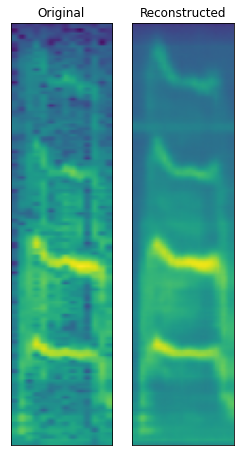

In [187]:
plot_rec(9)

In [11]:
latent = encoder.predict(x_test)[0]
latent.shape

(8761, 10)

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
#, perplexity=4, early_exaggeration=12.0,
#     learning_rate=20.0, n_iter=300, n_iter_without_progress=200,
#     min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
#     random_state=None, method='barnes_hut', angle=0.5)
tsne_val = tsne.fit_transform(latent)

In [13]:
tsne_val.shape

(8761, 2)

In [18]:
import pandas as pd
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2.4, min_samples=60)
predict = model.fit(tsne_val)
y_pred = predict.labels_

In [33]:
from sklearn.cluster import KMeans

model = KMeans(init="k-means++", n_clusters=15, random_state=0)
model.fit(tsne_val)
y_pred = model.labels_

In [90]:
max(y_pred)

14

In [188]:
def plot_scatter(data, y_pred, gidx=None, size=10, save = None):
    
    plt.figure()
    plt.figure(figsize=(size,size))
    ax = plt.subplot()
    
    x = data[:,0]
    y = data[:,1]
    
    xmin = min(x)-0.5
    xmax = max(x)+0.5
    ymin = min(y)-0.5
    ymax = max(y)+0.5
    print(xmin, xmax, ymin, ymax)
    plt.axis((xmin, xmax, ymin, ymax))

    c = ['orangered', 
        'orange', 
         'yellow',
         'yellowgreen',
         'lightgreen',
         'darkturquoise',
         'deepskyblue',
         'black',
         'steelblue',
         'slateblue',
         'darkviolet',
         'plum', 
         'purple', 
         'magenta', 
         'deeppink', 
         'pink']
    
    if gidx != None:
        cond = y_pred == gidx
        g = data[cond]
        gx = g[:, 0]
        gy = g[:, 1]
        plt.scatter(gx, gy, color = c[gidx], marker='o', label = str(gidx))
        plt.legend(prop={'size': size*2})
    
    else:    
        for i in range(max(y_pred)+1):
            cond = y_pred == i
            g = data[cond]
            gx = g[:,0]
            gy = g[:,1]
            plt.scatter(gx, gy, color = c[3], marker='o', label=str(i))

#        plt.legend(prop={'size': size})
    
    
    if save != None:
        plt.savefig(save)
    plt.show()
    
def plot_group(x_data, y_data, gidx, save='n'):
    
    x, y = 2, 10
    fig = plt.figure(figsize=(y,x*4))
    
    cond = y_data == gidx
    g_data = x_data[cond]
    
    for i in range(x):
        for j in range(y):
            idx = i*y+j
            plt.subplot(x, y, idx+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(g_data[idx])
    fig.suptitle('Group %s'%(str(gidx)), fontsize=30)
    if save != None:
        plt.savefig(save+'gidx_%s'%(str(gidx)))
    plt.show() 

In [125]:
save_path = 'data/w58y67_prepro/train_2/'

-86.8501205444336 78.07854461669922 -84.12800598144531 84.78475189208984


<Figure size 432x288 with 0 Axes>

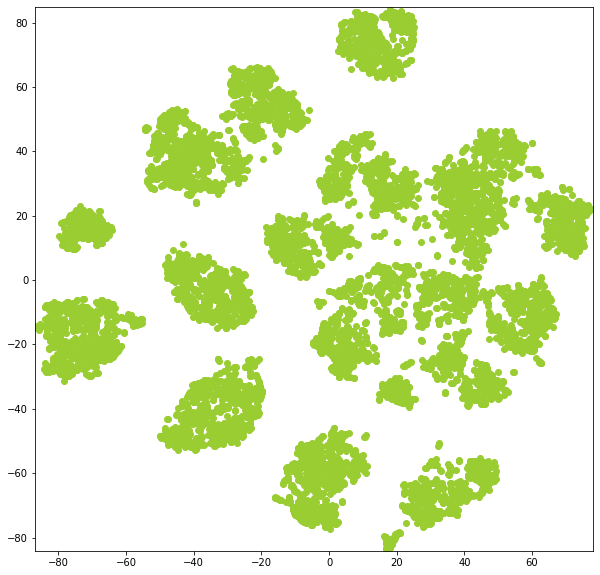

In [190]:
plot_scatter(tsne_val, y_pred,  size = 10, save = save_path + 'scatter')

-86.8501205444336 78.07854461669922 -84.12800598144531 84.78475189208984


<Figure size 432x288 with 0 Axes>

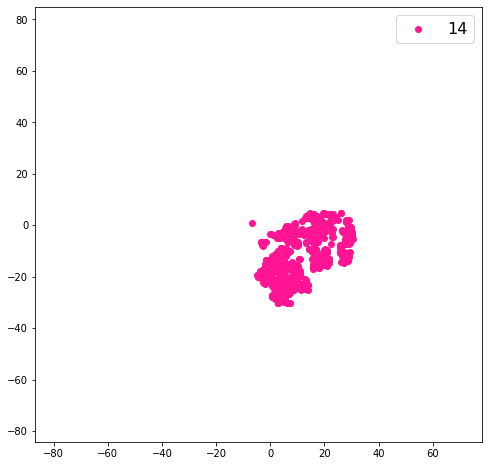

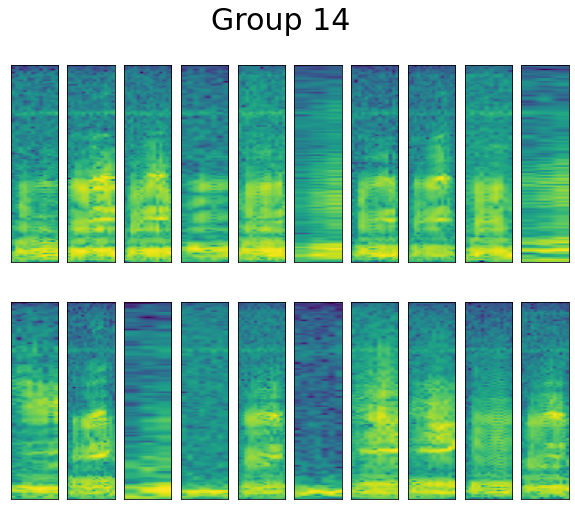

In [180]:
idx = 14
plot_scatter(tsne_val, y_pred, idx, size =8)
plot_group(x_test, y_pred, idx, save = save_path)